# SMOTE over-sampling

### Get X and y back

In [ ]:
X = f1_f2_gtv_df # X 

In [ ]:
y = cleaned_outcome_df['Recurrence']
y

Patient 1      True
Patient 2      True
Patient 3      True
Patient 4      True
Patient 5      True
              ...  
Patient 82     True
Patient 83     True
Patient 84     True
Patient 85     True
Patient 86    False
Name: Recurrence, Length: 85, dtype: bool

### Perform over-sampling 

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='minority', random_state=42, k_neighbors=5)
X_sampled, Y_sampled = sm.fit_resample(X, y)
print(X_sampled.shape, Y_sampled.shape)

ValueError: could not convert string to float: 'delta_f1_f2_gtv_original_shape_Elongation'

In [ ]:
Y_sampled.value_counts()


Recurrence
True     63
False    63
Name: count, dtype: int64

## Separate in train and test 

In [ ]:
from sklearn.model_selection import train_test_split 
X_train, X_val, y_train, y_val = train_test_split(X_sampled, Y_sampled, test_size=0.3, random_state=42)

In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_val.shape)
print("Y_train shape:", y_train.shape)
print("Y_test shape:", y_val.shape)    

X_train shape: (88, 107)
X_test shape: (38, 107)
Y_train shape: (88,)
Y_test shape: (38,)


## Normalize 

In [ ]:
znorm_scaler = StandardScaler()
znorm_scaled_x_train = znorm_scaler.fit(X_train)
znorm_scaled_x_train = znorm_scaler.transform(X_train)
znorm_scaled_x_train = pd.DataFrame(znorm_scaled_x_train, columns=X_train.columns)

In [ ]:
znorm_scaled_x_val = znorm_scaler.fit(X_val)
znorm_scaled_x_val = znorm_scaler.transform(X_val)
znorm_scaled_x_val = pd.DataFrame(znorm_scaled_x_val, columns=X_val.columns)

### avoid df errors

In [ ]:
y_train = y_train.values.reshape(-1, 1).ravel() # to avoid errors
y_val = y_val.values.reshape(-1, 1).ravel() # to avoid errors

# Apply random Forest with cross validation
The idea is to identify using the Gini index, which features are the most predictive for patient outcome. For that we plot the feature importance (using plot_importances). 


In [ ]:
param_grid = {'max_depth': range(1, 21, 4), 'n_estimators' : range(25, 1001, 25)} # maximimum depth tuning

scorer = 'f1'
estimator = RandomForestClassifier(random_state=42) 

grid_rf = sku.hyper_parameters_search(estimator, znorm_scaled_x_train, y_train, param_grid, scorer=scorer, cv=5)

best mean cross-validation score: 0.668
best parameters: {'max_depth': 1, 'n_estimators': 350}


## Select two most important features from RF


Top 5 features:
delta_f1_f2_gtv_original_shape_Maximum2DDiameterSlice: 0.0600
delta_f1_f2_gtv_original_firstorder_Minimum: 0.0600
delta_f1_f2_gtv_original_gldm_SmallDependenceLowGrayLevelEmphasis: 0.0429
delta_f1_f2_gtv_original_glrlm_LowGrayLevelRunEmphasis: 0.0400
delta_f1_f2_gtv_original_shape_Elongation: 0.0371


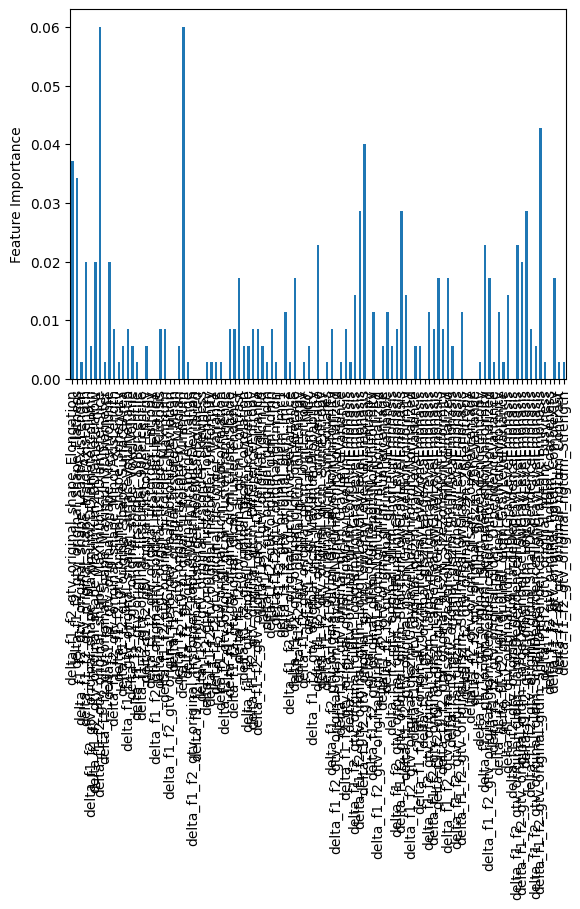

In [ ]:
best_features = disp_best_features(grid_rf.best_estimator_.feature_importances_, znorm_scaled_x_train.columns, n_features=5)
sku.plot_importances(grid_rf.best_estimator_.feature_importances_, znorm_scaled_x_train.columns)

### Drop useless features

In [ ]:
X_train_filtered = znorm_scaled_x_train[best_features.keys()] # drop all features but the five best 
X_val_filtered = znorm_scaled_x_val[best_features.keys()]
print(X_train_filtered.shape)

(88, 5)


In [ ]:
X_val_filtered.head()

,delta_f1_f2_gtv_original_shape_Maximum2DDiameterSlice,delta_f1_f2_gtv_original_firstorder_Minimum,delta_f1_f2_gtv_original_gldm_SmallDependenceLowGrayLevelEmphasis,delta_f1_f2_gtv_original_glrlm_LowGrayLevelRunEmphasis,delta_f1_f2_gtv_original_shape_Elongation
0,0.027307,0.865248,0.034893,-0.489724,-0.170189
1,0.027307,-1.230000,0.469631,-0.107365,-0.109466
2,0.508509,-0.278150,-0.254030,-0.421811,-0.140194
3,0.027307,1.146248,-0.327277,-0.756744,-0.183031
4,-0.111735,0.601417,-0.571903,0.066802,-0.153138


## Use these two most important features to predict outcome

In [ ]:
param_grid = {'max_depth': range(1, 21, 4), 'n_estimators' : range(25, 1001, 25)} # maximimum depth tuning

scorer = 'f1'
estimator = RandomForestClassifier(random_state=42) 

grid_rf = sku.hyper_parameters_search(estimator, X_train_filtered, y_train, param_grid, scorer=scorer, cv=5)

best mean cross-validation score: 0.645
best parameters: {'max_depth': 1, 'n_estimators': 100}


PERFORMANCE METRICS
	TRAIN	TEST
ACC:	71.59	44.74
SEN:	62.22	22.22
ESP:	81.40	65.00
PPV:	77.78	36.36
F1:	69.14	27.59


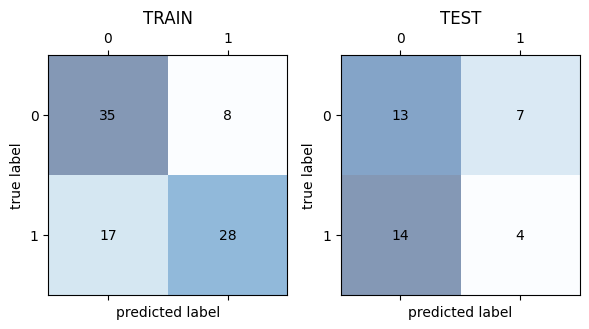

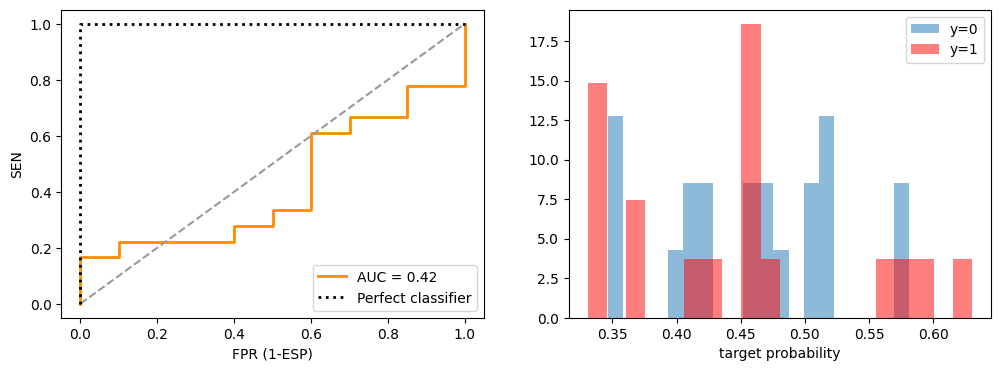

In [ ]:
rf_model =  grid_rf.best_estimator_ 
sku.analyze_train_test_performance(rf_model, X_train_filtered, X_val_filtered, y_train, y_val)